# Wind Impact on LSTM Agent Performance

How robust is the RL architecture trained with wind estimations (from an LSTM) all wind?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from utilities import get_agent
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from stable_baselines3 import PPO

In [2]:
# study, best_agent, best_params = get_agent('windlstm')

# best_params['bounding_rect_length']=200
# best_params['steps_u']=50

In [3]:
best_agent = PPO.load('./saved_models/lstm_agent') 

In [4]:
best_params = {'steps_u':50, 'scaling_factor':4, 'window_distance':1000}

In [5]:
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])

In [6]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
            ttes.append(tte)
                
        return np.array(ttes)

In [7]:
def toc(tte: np.ndarray):
    corridor = 5
    return best_params['steps_u'] * len(tte[tte > corridor]) / 100

In [8]:
def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 0.65):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [9]:
def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params):
    env = env_selector.get_env("lstm", params, wind_ranges, square_wpts, start_alt=30, has_turbulence=True)
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, 
                      other_vars=('reward','next_wp'))
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        action = [0,0,0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward, next_wp=env.base_env.next_waypt)

    log.done_logging()
    return log, info

In [10]:
wind_range_dict = {
    'zero': [(0,0), (0,0), (0,0)],
    # 'n5': [(0,0), (5,5), (0,0)],
    # 'n7': [(0,0), (7,7), (0,0)],
    # 'n10': [(0,0), (10,10), (0,0)],
    # 's5': [(0,0), (-5,-5), (0,0)],
    # 's7': [(0,0), (-7,-7), (0,0)],
    # 's10': [(0,0), (-10,-10), (0,0)],
    # 'e5': [(5,5), (0,0), (0,0)],
    # 'e7': [(7,7), (0,0), (0,0)],
    # 'e10': [(10,10), (0,0), (0,0)],
    # 'w5': [(-5,-5), (0,0), (0,0)],
    # 'w7': [(-7,-7), (0,0), (0,0)],
    # 'w10': [(-10,-10), (0,0), (0,0)],
    # 'nw5': [(-3.53553391,-3.53553391), (3.53553391,3.53553391), (0,0)],
    # 'nw7': [(-4.94974747,-4.94974747), (4.94974747,4.94974747), (0,0)],
    # 'nw10': [(-7.07106781,-7.07106781), (7.07106781,7.07106781), (0,0)],
    # 'sw5': [(-3.53553391,-3.53553391), (-3.53553391,-3.53553391), (0,0)],
    # 'sw7': [(-4.94974747,-4.94974747), (-4.94974747,-4.94974747), (0,0)],
    # 'sw10': [(-7.07106781,-7.07106781), (-7.07106781,-7.07106781), (0,0)],
    # 'ne5': [(3.53553391,3.53553391), (3.53553391,3.53553391), (0,0)],
    # 'ne7': [(4.94974747,4.94974747), (4.94974747,4.94974747), (0,0)],
    # 'ne10': [(7.07106781,7.07106781), (7.07106781,7.07106781), (0,0)],
    # 'se5': [(3.53553391,3.53553391), (-3.53553391,-3.53553391), (0,0)],
    # 'se7': [(4.94974747,4.94974747), (-4.94974747,-4.94974747), (0,0)],
    # 'se10': [(7.07106781,7.07106781), (-7.07106781,-7.07106781), (0,0)],
}

In [11]:
wind_results = pd.DataFrame(columns=['Wind', 'Total TTE', 'Mean TTE', 'Completed Mission', 'Reward', 'Time Outside Corridor'])

In [12]:
def run_wind_sweep(results, wind_dict, agent, params):
    for wind in tqdm(wind_dict.keys()):
        log, info = run_trajectory(env_selector, wind_dict[wind], agent, params)
        print(info)
        traj_err = get_tte(np.array([0,0,30]), log.next_wp, log.x, log.y, log.z)
        new_result = {
            'Wind': wind,
            'Mean TTE': np.mean(traj_err),
            'Total TTE': np.sum(traj_err),
            'Completed Mission': completed_mission(square_wpts, log.x, log.y, log.z, radius=5),
            'Reward': np.sum(log.reward),
            'Time Outside Corridor': toc(traj_err)
        }
        results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)

    return results, log

In [13]:
wind_results, log = run_wind_sweep(wind_results, wind_range_dict, best_agent, best_params)

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_2515599/677425443.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)
100%|██████████| 1/1 [00:14<00:00, 14.59s/it]

{'reached': False, 'outofbounds': True, 'outoftime': True, 'tipped': False, 'crashed': False}


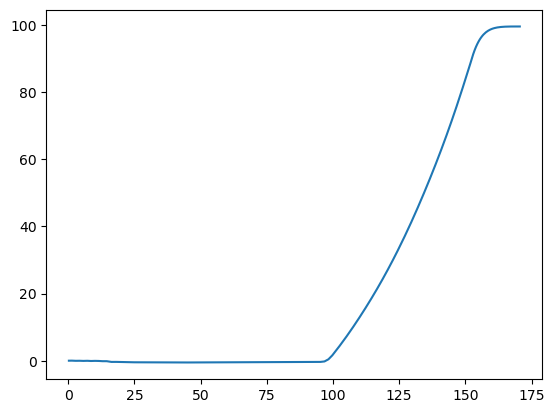

In [15]:
plt.plot(log.x, log.y)

In [16]:
info

NameError: name 'info' is not defined

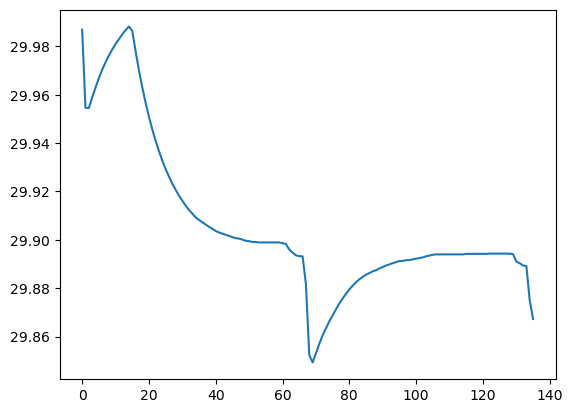

In [15]:
plt.plot(log.z)

In [77]:
wind_results.to_csv('./data/lstm_wind.csv')

In [84]:
wind_results = pd.read_csv('./data/lstm_wind.csv') 

In [85]:
wind_results

,Unnamed: 0,Wind,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor
0,0,zero,124.909102,1.086166,True,8840.5270,0.0
1,1,n5,142.149895,1.204660,True,8667.4940,0.0
2,2,n7,155.779091,1.287431,True,8533.5880,0.0
3,3,n10,221.322356,1.569662,True,7874.4116,0.0
4,4,s5,124.892180,1.076657,True,8829.8370,0.0
5,5,s7,130.677418,1.088978,True,8772.7210,0.0
6,6,s10,186.643402,1.323712,True,8208.4810,0.0
7,7,e5,133.603782,1.151757,True,8743.3950,0.0
8,8,e7,134.131805,1.108527,True,8744.3940,0.0
9,9,e10,182.265084,1.320761,True,8257.2350,0.0


In [73]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Reward'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Reward'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Reward'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Reward'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Reward'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Reward'].std())

Mean reward for 5 m/s:  8736.357
Std reward for 5 m/s:  81.24075
Mean reward for 7 m/s:  8636.789
Std reward for 7 m/s:  113.17812
Mean reward for 10 m/s:  8085.25
Std reward for 10 m/s:  241.5662


In [82]:
print("Mean for 0 m/s: ", wind_results[wind_results['Wind'].str.contains("zero")]['Mean TTE'].mean())
print("Mean for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Mean TTE'].mean())
print("Std for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Mean TTE'].std())
print("Mean for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Mean TTE'].mean())
print("Std for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Mean TTE'].std())
print("Mean for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Mean TTE'].mean())
print("Std for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Mean TTE'].std())

Mean for 0 m/s:  nan
Mean for 5 m/s:  nan
Std for 5 m/s:  nan
Mean for 7 m/s:  nan
Std for 7 m/s:  nan
Mean for 10 m/s:  nan
Std for 10 m/s:  nan


In [75]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Time Outside Corridor'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Time Outside Corridor'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Time Outside Corridor'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Time Outside Corridor'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Time Outside Corridor'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Time Outside Corridor'].std())

Mean reward for 5 m/s:  0.0
Std reward for 5 m/s:  0.0
Mean reward for 7 m/s:  0.0
Std reward for 7 m/s:  0.0
Mean reward for 10 m/s:  0.0
Std reward for 10 m/s:  0.0


In [7]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Completed Mission'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Completed Mission'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Completed Mission'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Completed Mission'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Completed Mission'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Completed Mission'].std())

Mean reward for 5 m/s:  1.0
Std reward for 5 m/s:  0.0
Mean reward for 7 m/s:  1.0
Std reward for 7 m/s:  0.0
Mean reward for 10 m/s:  1.0
Std reward for 10 m/s:  0.0
